# $Modeling$

## Imports

In [47]:
import numpy as np
import pandas as pd
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w
import explore as e

# 1. Select a dataset with a continuous target variable.

In [3]:
# wrangel zillow data
df = w.wrangle_single_family_residential()

In [4]:
df = w.remove_outliers(df,['bedroom','bathroom','squarefeet','taxamount','tax_value'])

# 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [5]:
# Split data to train , test validate, using random state 123
train, validate, test = w.split_data(df)

In [8]:
train.dtypes

bedroom       float64
bathroom      float64
squarefeet    float64
tax_value     float64
yearbuilt     float64
taxamount     float64
fips           object
home_age      float64
dtype: object

# 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [22]:
# set up dataframe for predictions, add actual values
predictions = pd.DataFrame({
    'actual': validate.tax_value
}) 

In [24]:
predictions.head()

,actual
1292142,224327.0
2058386,146000.0
1883615,489000.0
1580431,269076.0
711630,104263.0


### **Simple Model**

In [25]:
# X must be 2-d array
X_train = train[['taxamount']]
# y can be 1-d array
y_train = train.tax_value

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['taxamount']]
predictions['simple_lm'] = lm.predict(X_validate)

In [26]:
predictions.head()

,actual,simple_lm
1292142,224327.0,216633.023808
2058386,146000.0,204330.521354
1883615,489000.0,481736.907417
1580431,269076.0,253885.366359
711630,104263.0,111585.069010


In [27]:
# look into modesl make up 
lm.coef_, lm.intercept_

(array([84.51842851]), -16365.68954562716)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


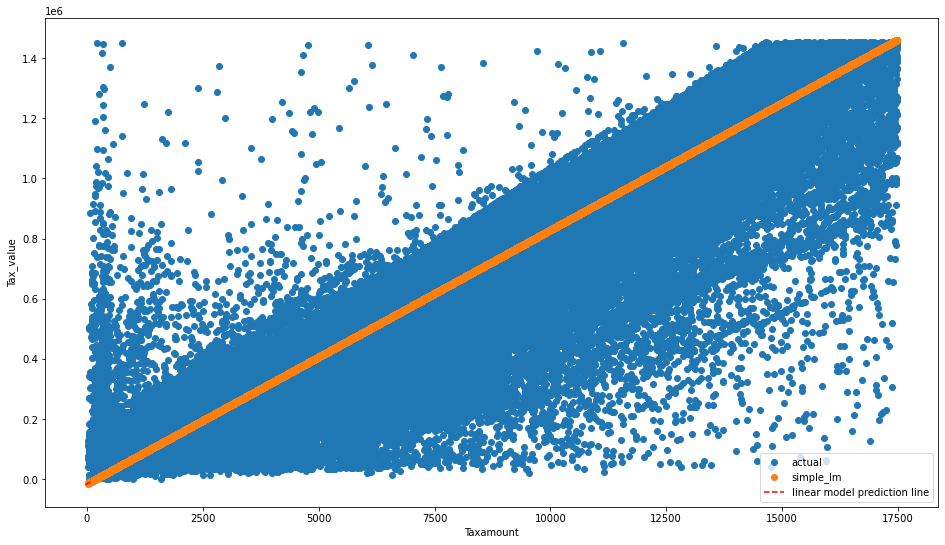

In [33]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.taxamount, train.tax_value, label='actual')
plt.scatter(train.taxamount, lm.predict(train[['taxamount']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='red', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Taxamount')
plt.ylabel('Tax_value')
plt.legend()

In [35]:
print('tax_value = {:.3f} * taxamount + {:.3f}'.format(lm.coef_[0], lm.intercept_))

tax_value = 84.518 * taxamount + -16365.690


In [41]:
train.tax_value.max()

1454758.0

In [43]:
taxamount = np.arange(train.taxamount.min(), train.taxamount.max())
tax_value = lm.predict(taxamount.reshape(-1, 1))
pd.DataFrame(dict(taxamount=taxamount, predicted_home_value=tax_value))

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,taxamount,predicted_home_value
0,16.48,-1.497283e+04
1,17.48,-1.488831e+04
2,18.48,-1.480379e+04
3,19.48,-1.471927e+04
4,20.48,-1.463475e+04
...,...,...
17463,17479.48,1.460972e+06
17464,17480.48,1.461057e+06
17465,17481.48,1.461142e+06
17466,17482.48,1.461226e+06


### Multiple Regression + RFE

In [49]:
X_train = train.drop(columns=['tax_value','fips','yearbuilt'])
y_train = train.tax_value
X_validate = validate.drop(columns=['tax_value','fips','yearbuilt'])

lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

selected top 2 features: Index(['bedroom', 'bathroom'], dtype='object')


In [50]:
X_train.shape

(1145530, 5)

In [51]:
X_train_rfe.shape

(1145530, 2)

In [52]:
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

,actual,simple_lm,multiple_rfe
1292142,224327.0,216633.023808,340649.388370
2058386,146000.0,204330.521354,355188.019470
1883615,489000.0,481736.907417,419780.457533
1580431,269076.0,253885.366359,355188.019470
711630,104263.0,111585.069010,340649.388370


In [53]:
# look into models make up
lm.coef_, lm.intercept_

(array([-14538.63109986, 158262.1383257 ]), 82279.63611829915)

In [55]:
print(f'tax_value = {lm.coef_[0]:.2f} x bedroom + {lm.coef_[1]:.2f} x bathroom + {lm.intercept_:.2f}')

tax_value = -14538.63 x bedroom + 158262.14 x bathroom + 82279.64


In [54]:
X = pd.DataFrame({
    'bedrooms': train.bedroom,
    'bathrooms': train.bathroom
})

X['predicted_tax_value'] = lm.predict(X)
X

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,bedrooms,bathrooms,predicted_tax_value
717802,3.0,1.0,196925.881144
664602,3.0,3.0,513450.157796
91875,2.0,1.0,211464.512244
1390318,5.0,3.0,484372.895596
1287692,3.0,2.0,355188.019470
...,...,...,...
122849,3.0,2.0,355188.019470
1505697,4.0,2.0,340649.388370
105279,4.0,2.0,340649.388370
1188418,4.0,3.0,498911.526696
